# IAB딥러닝 9월 27일
> 딥러닝의 기초 - 회귀분석(3) --> step4의 다른표현(옵티마이저), 로지스틱(1)

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김준형

# Import

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# plt.plot 오류 발생 시 사용

## numpy와 torch는 비슷하다
`-` torch.tensor() = np.array()처럼 생각해도 무방

In [3]:
np.array([1, 2, 3]), torch.tensor([1, 2, 3])

(array([1, 2, 3]), tensor([1, 2, 3]))

`-` 소수점 정밀도 차이가 조금 있음

In [4]:
np.array([3.123456789]), torch.tensor([3.123456789])

(array([3.12345679]), tensor([3.1235]))

`-` 기본적인 문법은 numpy 대신 torch를 사용해도 괜찮음 // 완전 같지는 않다

In [5]:
np.arange(10), torch.arange(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [6]:
np.linspace(0, 1, 10), torch.linspace(0, 1, 10)

(array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
        0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
 tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000]))

In [7]:
np.random.randn(10), torch.randn(10)

(array([-0.0394819 , -1.28231185,  0.52968028, -0.46039897,  0.86816715,
         0.34182877, -0.79434121, -0.45743091, -0.64380063,  0.31566267]),
 tensor([ 1.5308,  0.3064,  2.1564, -0.6753, -0.5874, -0.1225, -0.7329, -0.8632,
          0.7037,  0.7644]))

## length $n$ vector, $n \times 1$ col-vector, $1 \times n$ row-vector 

`-` 길이가 3인 벡터 선언방법

In [9]:
a = torch.tensor([1, 2, 3])
a.shape

torch.Size([3])

`-` 3x1 col-vec 선언방법

(방법1)

In [10]:
a = torch.tensor([[1], [2], [3]])
a.shape

torch.Size([3, 1])

(방법2)

In [11]:
a = torch.tensor([1, 2, 3]).reshape(3, 1)
a.shape

torch.Size([3, 1])

`-` 1x3 row-vec 선언방법

(방법1)

In [13]:
a = torch.tensor([[1, 2, 3]])
a.shape

torch.Size([1, 3])

(방법2)

In [14]:
a = torch.tensor([1, 2, 3]).reshape(1, 3)
a.shape

torch.Size([1, 3])

## torch의 dtype

`-` 기본적으로 torch는 소수점으로 저장되면 dtype = torch.float32로 설정

In [15]:
tsr = torch.tensor([1.23, 2.34])
tsr

tensor([1.2300, 2.3400])

In [16]:
tsr.dtype

torch.float32

`-` 정수로 선언하더라고 dtype을 torch.float32로 설정하는게 유리함

In [17]:
tsr = torch.tensor([1, 2])
tsr

tensor([1, 2])

In [18]:
tsr.dtype

torch.int64

(좋은예시 1)

In [19]:
tsr = torch.tensor([1, 2], dtype = torch.float32)
tsr

tensor([1., 2.])

In [20]:
tsr.dtype

torch.float32

(좋은예시 2)

In [21]:
tsr = torch.tensor([1, 2.0])
tsr

tensor([1., 2.])

In [22]:
tsr.dtype

torch.float32

(int로 선언 후 float으로 변경 가능)

In [23]:
tsr = torch.tensor([1, 2]).float()
tsr

tensor([1., 2.])

In [24]:
tsr.dtype

torch.float32

## Shape of Vector

`-` 행렬곱셈에 대한 shape 조심

In [25]:
A = torch.tensor([[2.00, 0.00], [0.00, 3.00]])
b1 = torch.tensor([[-1.0, -5.0]])
b2 = torch.tensor([[-1.0], [-5.0]])
b3 = torch.tensor([-1.0, -5.0])

In [26]:
A.shape, b1.shape, b2.shape, b3.shape

(torch.Size([2, 2]), torch.Size([1, 2]), torch.Size([2, 1]), torch.Size([2]))

`-` A @ b1은 계산 불가능 / b1 @ A는 계산 가능

In [27]:
A @ b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x2 and 1x2)

In [28]:
b1 @ A

tensor([[ -2., -15.]])

`-` A @ b2는 계산 가능 / b2 @ A는 계산 불가능

In [29]:
A @ b2

tensor([[ -2.],
        [-15.]])

In [30]:
b2 @ A

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x1 and 2x2)

`-` A @ b3는 계산 가능 / b3 @ A는 계산 가능

In [31]:
A @ b3

tensor([ -2., -15.])

In [32]:
(A @ b3).shape

torch.Size([2])

In [33]:
b3 @ A

tensor([ -2., -15.])

In [34]:
(b3 @ A).shape

torch.Size([2])

`-` 브로드캐스팅

In [35]:
a = torch.tensor([1, 2, 3])
a - 1

tensor([0, 1, 2])

In [36]:
b = torch.tensor([[1], [2], [3]])
b - 1

tensor([[0],
        [1],
        [2]])

In [37]:
a - b

tensor([[ 0,  1,  2],
        [-1,  0,  1],
        [-2, -1,  0]])

# Step 1의 다른버전 (복습 + $\alpha$)

## read data

In [38]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-09-22-regression.csv") 
df

,x,y
0,-2.482113,-8.542024
1,-2.362146,-6.576713
2,-1.997295,-5.949576
3,-1.623936,-4.479364
4,-1.479192,-4.251570
...,...,...
95,2.244400,10.325987
96,2.393501,12.266493
97,2.605604,13.098280
98,2.605658,12.546793


In [39]:
x = torch.tensor(df.x).float().reshape(100, 1)
y = torch.tensor(df.y).float().reshape(100, 1)
_1 = torch.ones([100, 1])
X = torch.concat([_1, x], axis = 1)

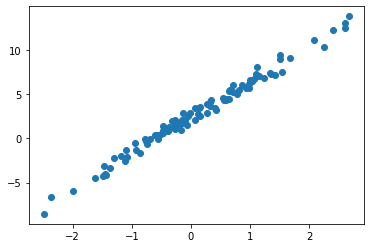

In [40]:
plt.plot(x, y, 'o')

## ver1 : net = torch.nn.Linear(1, 1, bias = True)

`-` 준비

In [41]:
net = torch.nn.Linear(1, 1, bias = True)
net.weight.data = torch.tensor([[10.0]])
net.bias.data = torch.tensor([-5.0])
net.weight, net.bias

(Parameter containing:
 tensor([[10.]], requires_grad=True),
 Parameter containing:
 tensor([-5.], requires_grad=True))

`-` step 1

In [42]:
yhat = net(x)

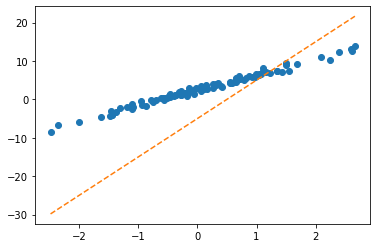

In [43]:
plt.plot(x, y, 'o')
plt.plot(x, net(x).data, '--')

`-` step 2

In [44]:
loss = torch.mean((y - yhat) ** 2)

`-` step 3

(미분 전)

In [45]:
net.bias, net.weight

(Parameter containing:
 tensor([-5.], requires_grad=True),
 Parameter containing:
 tensor([[10.]], requires_grad=True))

In [46]:
net.bias.grad, net.weight.grad

(None, None)

(미분)

In [47]:
loss.backward()

(미분 후)

In [48]:
net.bias, net.weight

(Parameter containing:
 tensor([-5.], requires_grad=True),
 Parameter containing:
 tensor([[10.]], requires_grad=True))

In [49]:
net.bias.grad, net.weight.grad

(tensor([-13.4225]), tensor([[11.8893]]))

`-` step 4

(업데이터 전)

In [50]:
net.bias, net.weight

(Parameter containing:
 tensor([-5.], requires_grad=True),
 Parameter containing:
 tensor([[10.]], requires_grad=True))

In [51]:
net.bias.grad, net.weight.grad

(tensor([-13.4225]), tensor([[11.8893]]))

(업데이트)

In [52]:
net.bias.data = net.bias.data - 0.1 * net.bias.grad
net.weight.data = net.weight.data - 0.1 * net.weight.grad

In [53]:
net.bias.grad = None
net.weight.grad = None

(업데이트 후)

In [54]:
net.bias, net.weight

(Parameter containing:
 tensor([-3.6577], requires_grad=True),
 Parameter containing:
 tensor([[8.8111]], requires_grad=True))

In [55]:
net.bias.grad, net.weight.grad

(None, None)

`-` 반복

In [56]:
for epoch in range(30):
    yhat = net(x)
    loss = torch.mean((y - yhat) ** 2)
    loss.backward()
    net.weight.data = net.weight.data - 0.1 * net.weight.grad
    net.bias.data = net.bias.data - 0.1 * net.bias.grad
    net.weight.grad = None
    net.bias.grad = None

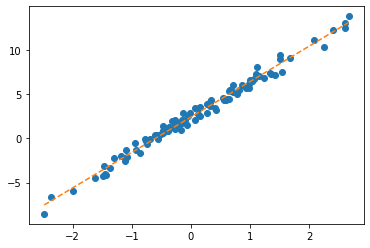

In [57]:
plt.plot(x, y, 'o')
plt.plot(x, net(x).data, '--')

## ver2 : net = torch.nn.Linear(2, 1, bias = False)

`-` 준비

In [58]:
net = torch.nn.Linear(2, 1, bias = False)
net.weight.data = torch.tensor([[-5.0, 10.0]])

`-` step 1

In [60]:
yhat = net(X)

`-` step 2

In [61]:
loss = torch.mean((y - yhat) ** 2)

`-` step 3

(미분 전)

In [62]:
net.weight

Parameter containing:
tensor([[-5., 10.]], requires_grad=True)

In [63]:
net.weight.grad

(미분)

In [64]:
loss.backward()

(미분 후)

In [65]:
net.weight

Parameter containing:
tensor([[-5., 10.]], requires_grad=True)

In [66]:
net.weight.grad

tensor([[-13.4225,  11.8893]])

`-` step 4

(업데이트 전)

In [67]:
net.weight

Parameter containing:
tensor([[-5., 10.]], requires_grad=True)

In [68]:
net.weight.grad

tensor([[-13.4225,  11.8893]])

(업데이트)

In [69]:
net.weight.data = net.weight.data - 0.1 * net.weight.grad

In [70]:
net.weight.grad = None

(업데이트 후)

In [71]:
net.weight

Parameter containing:
tensor([[-3.6577,  8.8111]], requires_grad=True)

In [72]:
net.weight.grad

`-` 반복

In [73]:
net = torch.nn.Linear(2, 1, bias = False)
net.weight.data = torch.tensor([[-5.0, 10.0]])

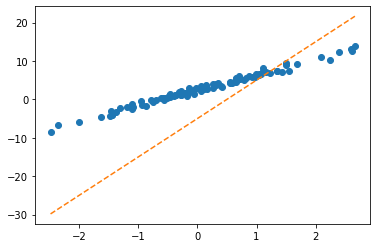

In [74]:
plt.plot(x, y, 'o')
plt.plot(x, net(X).data, '--')

In [75]:
for epoch in range(30):
    yhat = net(X)
    loss = torch.mean((y - yhat) ** 2)
    loss.backward()
    net.weight.data = net.weight.data - 0.1 * net.weight.grad
    net.weight.grad = None

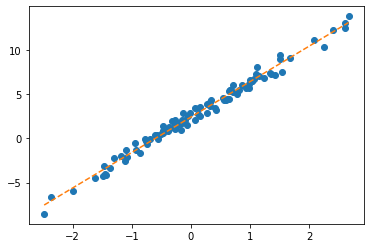

In [76]:
plt.plot(x, y, 'o')
plt.plot(x, net(X).data, '--')

# step 4의 다른버전 : 옵티마이저

## ver 1 : net = torch.nn.Linear(1, 1, bias = True)

`-` 준비

In [77]:
net = torch.nn.Linear(1, 1)
net.weight.data = torch.tensor([[10.0]])
net.bias.data = torch.tensor([[-5.0]])

In [78]:
optimizer = torch.optim.SGD(net.parameters(), lr = 1 / 10)

`-` step 1 ~ 3

In [79]:
yhat = net(x)

In [80]:
loss = torch.mean((y - yhat) ** 2)

In [81]:
loss.backward()

`-` step 4

(업데이트 전)

In [82]:
net.weight.data, net.bias.data

(tensor([[10.]]), tensor([[-5.]]))

In [83]:
net.weight.grad, net.bias.grad

(tensor([[11.8893]]), tensor([[-13.4225]]))

(업데이트)

In [84]:
optimizer.step()
optimizer.zero_grad()

(업데이트 후)

In [85]:
net.weight.data, net.bias.data

(tensor([[8.8111]]), tensor([[-3.6577]]))

In [86]:
net.weight.grad, net.bias.grad

(tensor([[0.]]), tensor([[0.]]))

`-` 반복

In [87]:
net = torch.nn.Linear(1, 1)
net.weight.data = torch.tensor([[10.0]])
net.bias.data = torch.tensor([-5.0])
optimizer = torch.optim.SGD(net.parameters(), lr = 1 / 10)

In [88]:
for epoch in range(30):
    yhat = net(x)
    loss = torch.mean((y - yhat) ** 2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

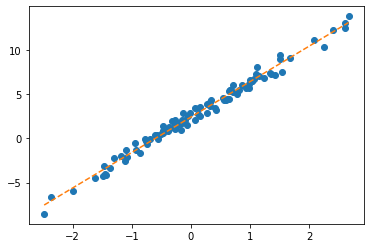

In [89]:
plt.plot(x, y, 'o')
plt.plot(x, net(x).data, '--')

## ver2 : torch.nn.Linear(2, 1, bias = False)

In [90]:
net = torch.nn.Linear(2, 1, bias = False)
net.weight.data = torch.tensor([[-5.0, 10.0]])
optimizer = torch.optim.SGD(net.parameters(), lr = 1 / 10)

In [91]:
for epoch in range(30):
    yhat = net(X)
    loss = torch.mean((y - yhat) ** 2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

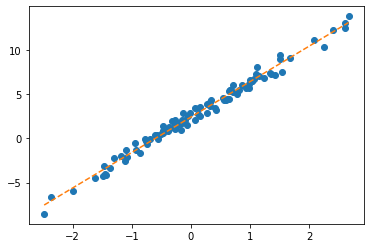

In [92]:
plt.plot(x, y, 'o')
plt.plot(x, net(X).data, '--')

# Appendix : `net.parameters()`의 의미

`-` iterator, generator의 개념 필요

`-` 네트워크 생성

In [93]:
net = torch.nn.Linear(in_features = 1, out_features = 1)
net.weight

Parameter containing:
tensor([[-0.1294]], requires_grad=True)

In [94]:
net.bias

Parameter containing:
tensor([0.6951], requires_grad=True)

In [96]:
set(dir(net.parameters)) & {'__iter__'}

set()

In [97]:
set(dir(net.parameters())) & {'__iter__'}

{'__iter__'}

`-` 무슨 의미일까?

In [98]:
_generator = net.parameters()

In [99]:
_generator.__next__()

Parameter containing:
tensor([[-0.1294]], requires_grad=True)

In [100]:
_generator.__next__()

Parameter containing:
tensor([0.6951], requires_grad=True)

In [101]:
_generator.__next__()

StopIteration: 

`-` 이건 이런느낌?

In [102]:
_generator2 = iter([net.weight, net.bias])

In [103]:
_generator2

In [104]:
_generator2.__next__()

Parameter containing:
tensor([[-0.1294]], requires_grad=True)

In [105]:
_generator2.__next__()

Parameter containing:
tensor([0.6951], requires_grad=True)

In [106]:
_generator2.__next__()

StopIteration: 

`-` 즉, 아래의 코드는 같다

In [107]:
### 코드 1
_generator = net.parameters()
torch.optim.SGD(_generator, lr = 1 / 10)
### 코드 2
_generator = iter([net.weight, net.bias])
torch.optim.SGD(_generator, lr = 1 / 10)
### 코드 3
_iterator = [net.weight, net.bias]
torch.optim.SGD(_iterator, lr = 1 / 10)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

결론 : `net.parameters()`는 net오브젝트에서 학습할 파라미터를 모두 모아 리스트(iterable object)로 만드는 함수

`-` 응용예제 1

In [108]:
What = torch.tensor([[-5.0], [10.0]], requires_grad = True)
optimizer = torch.optim.SGD([What], lr = 1 / 10)

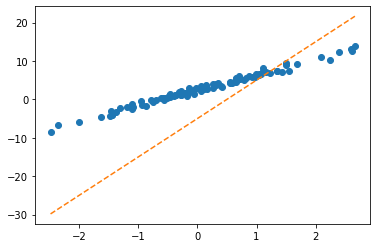

In [109]:
plt.plot(x, y, 'o')
plt.plot(x, (X @ What).data, '--')

In [110]:
for epoch in range(30):
    yhat = X @ What
    loss = torch.mean((y - yhat) ** 2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

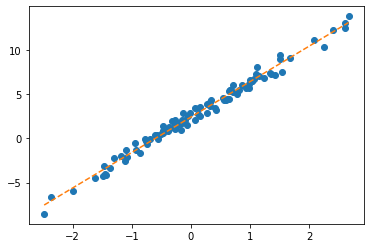

In [111]:
plt.plot(x, y, 'o')
plt.plot(x, (X @ What).data, '--')

`-` 응용예제 2

In [112]:
b = torch.tensor(-5.0, requires_grad = True)
w = torch.tensor(10.0, requires_grad = True)
optimizer = torch.optim.SGD([b, w], lr = 1 / 10)

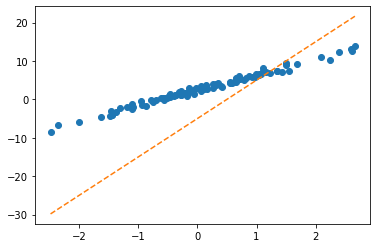

In [113]:
plt.plot(x, y, 'o')
plt.plot(x, (w * x + b).data, '--')

In [114]:
for epoch in range(30):
    yhat = b + w * x
    loss = torch.mean((y - yhat) ** 2)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

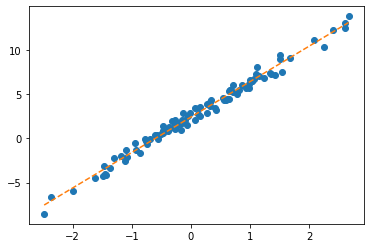

In [115]:
plt.plot(x, y, 'o')
plt.plot(x, (w * x + b).data, '--')

# Logistic regression

## motive

`-` 현실에 이런 경우가 많음
 - x가 커질수록 (혹은 작아질수록) 성공확률이 증가

`-` (X, y)는 어떤 모양?

In [117]:
_df = pd.DataFrame({'x':range(-6,7),'y':[0,0,0,0,0,0,1,0,1,1,1,1,1]})
_df

,x,y
0,-6,0
1,-5,0
2,-4,0
3,-3,0
4,-2,0
5,-1,0
6,0,1
7,1,0
8,2,1
9,3,1


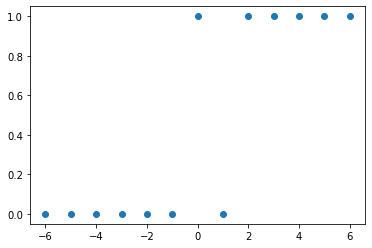

In [118]:
plt.plot(_df.x, _df.y, 'o')

`-` 시그모이드 함수 구현

In [119]:
xx = torch.linspace(-6, 6, 100)
def f(x):
    return torch.exp(x) / (1 + torch.exp(x))

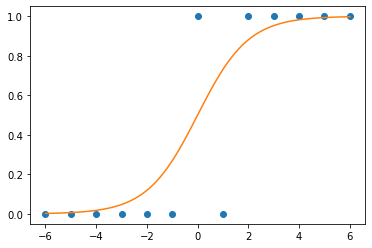

In [120]:
plt.plot(_df.x, _df.y, 'o')
plt.plot(xx, f(xx))

## model

`-` $x$가 커질수록 $y=1$이 잘나오는 모형은 아래와 같이 설계할 수 있음 <--- 외우세요!!!

- $y_i \sim Ber(\pi_i),\quad $ where $\pi_i = \frac{\exp(w_0+w_1x_i)}{1+\exp(w_0+w_1x_i)}$

- $\hat{y}_i= \frac{\exp(\hat{w}_0+\hat{w}_1x_i)}{1+\exp(\hat{w}_0+\hat{w}_1x_i)}=\frac{1}{1+\exp(-\hat{w}_0-\hat{w}_1x_i)}$ 

- $loss= - \sum_{i=1}^{n} \big(y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i)\big)$ <--- 외우세요!!

## toy example

`-` 예제시작

In [121]:
x = torch.linspace(-1, 1, 2000).reshape(2000, 1)
w0 = -1
w1 = 5
u = w0 + x * w1
v = torch.exp(u) / (1 + torch.exp(u))
y = torch.bernoulli(v)

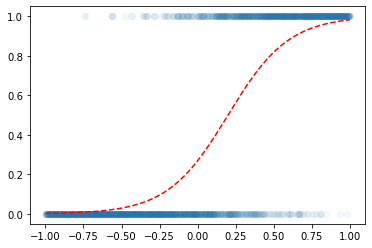

In [123]:
plt.scatter(x, y, alpha = 0.05)
plt.plot(x, v, '--r')

`-` IAB 딥러닝 수업 자료를 기반으로 공부한 내용입니다.